# Create model arquitecture

In [30]:
from tensorflow.keras import layers
from tensorflow import keras, dtypes
from tensorflow.data import Dataset
from tensorflow import feature_column

from preprocess_tf import preprocessing_fn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, target_name, shuffle=True, batch_size=100):
    dataframe = dataframe.copy()
    targets = dataframe.pop(target_name)
    ds = Dataset.from_tensor_slices((dict(dataframe), targets))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [4]:
def set_numerical_feature(name):
    
    numerical_feature = feature_column.numeric_column(name, dtype=dtypes.float64)
    
    return numerical_feature
    
def set_one_hot_feature(name, data):
    one_hot_feature = feature_column.categorical_column_with_vocabulary_list(name, data[name].unique().tolist())
    one_hot_feature = feature_column.indicator_column(one_hot_feature)
    
    return one_hot_feature

def set_embedding_feature(name, data, dims):
    embedding_feature = feature_column.categorical_column_with_vocabulary_list(name, data[name].unique().tolist())
    embedding_feature = feature_column.embedding_column(embedding_feature, dimension=dims)
    
    return embedding_feature

In [52]:
def feature_columns(data, dataset):
    
    feature_columns = []

    # numeric cols
    for header in ['yearOfRegistration', 'powerPS', 'kilometer']:
        feature_columns.append(set_numerical_feature(header))

    feature_columns.append(set_one_hot_feature('abtest', data))
    
    feature_columns.append(set_embedding_feature('vehicleType', data, 5))
    
    feature_columns.append(set_one_hot_feature('gearbox', data))
    
    #feature_columns.append(set_embedding_feature('model', data, 15))
    #feature_columns.append(set_one_hot_feature('model', data))
    
    feature_columns.append(set_one_hot_feature('fuelType', data))
    
    #feature_columns.append(set_embedding_feature('brand', data, 10))
    #feature_columns.append(set_one_hot_feature('brand', data))
    
    feature_columns.append(set_one_hot_feature('notRepairedDamage', data))
    
    #feature_columns.append(set_embedding_feature('postalCode', data, 10))
    feature_columns.append(set_one_hot_feature('cluster_pcode', data))
    
    feature_columns.append(set_one_hot_feature('cluster_model', data))
    
    feature_columns.append(set_one_hot_feature('cluster_brand', data))
    

    feature_layer = layers.DenseFeatures(feature_columns)
    
    return(feature_layer)

In [84]:
train = preprocessing_fn(path='data/train.csv', na_encoding='data/gearbox_powerps_na.csv', norm_params='data/numerical_features_normalization.csv', brand_clusters='data/brand_clusters.csv', model_clusters='data/model_clusters.csv', postalcode_clusters='data/postalcode_clusters.csv')
val = preprocessing_fn(path='data/val.csv', na_encoding='data/gearbox_powerps_na.csv', norm_params='data/numerical_features_normalization.csv', brand_clusters='data/brand_clusters.csv', model_clusters='data/model_clusters.csv', postalcode_clusters='data/postalcode_clusters.csv')

print(train.shape)
print(val.shape)

(165947, 12)
(49444, 12)


In [85]:
train.dtypes

price                   int64
abtest                 object
vehicleType            object
yearOfRegistration    float32
gearbox                object
powerPS               float32
kilometer             float32
fuelType               object
notRepairedDamage      object
cluster_brand           int32
cluster_model           int32
cluster_pcode           int32
dtype: object

In [86]:
train_ds = df_to_dataset(dataframe=train, target_name='price', shuffle=True, batch_size=512)
val_ds = df_to_dataset(dataframe=val, target_name='price', shuffle=True, batch_size=512)

In [87]:
feature_layer = feature_columns(train, train_ds)

Epoch 1/10
325/325 [==============================] - 6s 19ms/step - loss: 2783.1970 - mean_absolute_error: 2783.1970 - mean_squared_error: 13999833.0000 - val_loss: 3765.2078 - val_mean_absolute_error: 3765.2078 - val_mean_squared_error: 42689400.0000
Epoch 2/10
325/325 [==============================] - 6s 17ms/step - loss: 1257.0963 - mean_absolute_error: 1257.0963 - mean_squared_error: 3434831.7500 - val_loss: 2722.8188 - val_mean_absolute_error: 2722.8188 - val_mean_squared_error: 22684016.0000
Epoch 3/10
325/325 [==============================] - 6s 17ms/step - loss: 975.4496 - mean_absolute_error: 975.4496 - mean_squared_error: 2073456.5000 - val_loss: 2263.4150 - val_mean_absolute_error: 2263.4150 - val_mean_squared_error: 20775806.0000
Epoch 4/10
325/325 [==============================] - 6s 17ms/step - loss: 922.3260 - mean_absolute_error: 922.3260 - mean_squared_error: 1874135.3750 - val_loss: 2219.0054 - val_mean_absolute_error: 2219.0054 - val_mean_squared_error: 20828942.

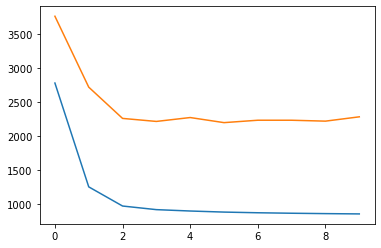

In [88]:
dp_rate = 0.2
lr = 0.001
hu = 150

model = keras.Sequential([
    feature_layer,
    layers.BatchNormalization(),
    layers.Dense(60, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(60, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=dp_rate),
    layers.Dense(120, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(120, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=dp_rate),
    layers.Dense(240, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(240, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=dp_rate),
    layers.Dense(120, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(60, activation='relu'),
    layers.Dense(1, activation='relu')
])

# Compile Keras model
model.compile(
    loss='mean_absolute_error',
    metrics=['mean_absolute_error','mean_squared_error'],
    optimizer=keras.optimizers.Adam(learning_rate=lr))

# fit model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# get results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(hist.epoch, hist.mean_absolute_error)
plt.plot(hist.epoch, hist.val_mean_absolute_error)

In [89]:
hist

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,2783.197021,2783.197021,1.399983e+07,3765.207764,3765.207764,42689400.0,0
1,1257.096313,1257.096313,3.434832e+06,2722.818848,2722.818848,22684016.0,1
2,975.449585,975.449585,2.073456e+06,2263.415039,2263.415039,20775806.0,2
3,922.325989,922.325989,1.874135e+06,2219.005371,2219.005371,20828942.0,3
4,902.166199,902.166199,1.792718e+06,2276.127441,2276.127441,21677284.0,4
5,886.355286,886.355286,1.730490e+06,2201.284668,2201.284668,20945352.0,5
6,876.450317,876.450317,1.701480e+06,2236.669434,2236.669434,21853868.0,6
7,869.367798,869.367798,1.665629e+06,2236.500488,2236.500488,21850974.0,7
8,863.863098,863.863098,1.644665e+06,2223.228760,2223.228760,21339008.0,8
9,859.451660,859.451660,1.632367e+06,2286.690186,2286.690186,22781270.0,9


In [90]:
train_pred = model.predict(df_to_dataset(dataframe=train, target_name='price', shuffle=False, batch_size=1000)).flatten() 

In [91]:
# super baseline model
np.mean(np.abs(train.price - train.price.mean()))

2138.1648503177207

In [92]:
# my model
np.mean(np.abs(train.price - train_pred))

895.2264776027741

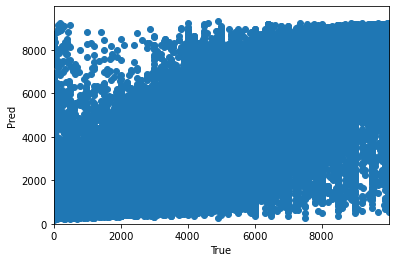

In [93]:
plt.scatter(train.price, train_pred)
plt.xlim([0, train.price.max()])
plt.ylim([0, train.price.max()])
plt.xlabel('True')
plt.ylabel('Pred')
plt.show()

In [94]:
train['price_pred'] = train_pred
train['abs_error'] = abs(train.price_pred - train.price)
train['error'] = train.price_pred - train.price

worst_predictions = train.copy().loc[train.abs_error >= train.abs_error.quantile(0.9)]

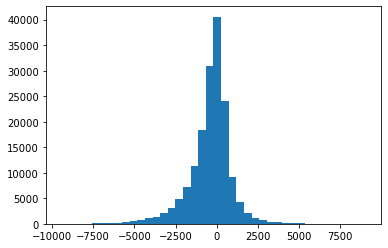

In [95]:
plt.hist(train.error, bins=40)
plt.show()

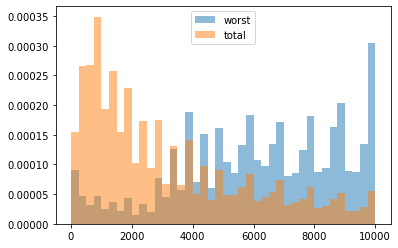

In [96]:
plt.hist(worst_predictions.price, bins=40, alpha=0.5, density=True, label='worst')
plt.hist(train.price, bins=40, alpha=0.5, density=True, label='total')
plt.legend()
plt.show()

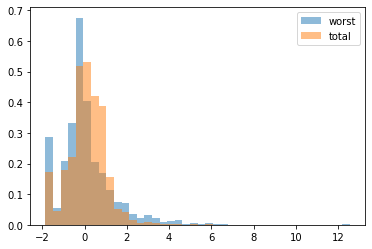

In [97]:
plt.hist(worst_predictions.yearOfRegistration, bins=40, alpha=0.5, density=True, label='worst')
plt.hist(train.yearOfRegistration, bins=40, alpha=0.5, density=True, label='total')
plt.legend()
plt.show()

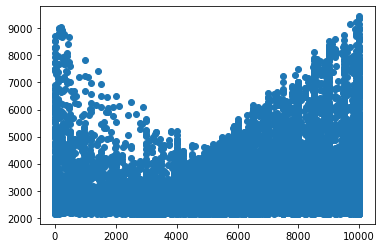

In [98]:
plt.scatter(worst_predictions.price, worst_predictions.abs_error)
plt.show()